In [2]:
#importing libraries
import pandas as pd
import numpy as np
import geopandas as gpd

# Plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score, GridSearchCV

# model explainability
import shap
import lime
from lime import lime_tabular


# train XGBoost 
import xgboost as xgb
import optuna # hyperparameter tuning

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Warning
import warnings
warnings.filterwarnings('ignore')


ohe = OneHotEncoder()
ss = StandardScaler()

## Import Data

In [15]:
%%time
# load dataset
setting = 'Village'
if setting == 'HH':
    data = pd.read_pickle('./data/processed/data_HH_1_12_22_10am.pck')
if setting == 'Village':
    data = pd.read_pickle('./data/processed/data_Villages_1_12_22_3pm_cat_percent_mean.pck')
    
# Target and independent variables
y = data['annual_consumption_2019']
y = y.reset_index()
X = data.drop(['annual_consumption_2019'],axis=1)
X_y = data

CPU times: user 12 ms, sys: 6.96 ms, total: 19 ms
Wall time: 87.3 ms


## Data Exploration

In [16]:
y['annual_consumption_2019'].describe().apply(lambda x: format(x, 'f'))

count     6304.000000
mean       389.940470
std       1727.234319
min          3.544828
25%         64.587160
50%        118.082458
75%        281.044172
max      64705.014286
Name: annual_consumption_2019, dtype: object

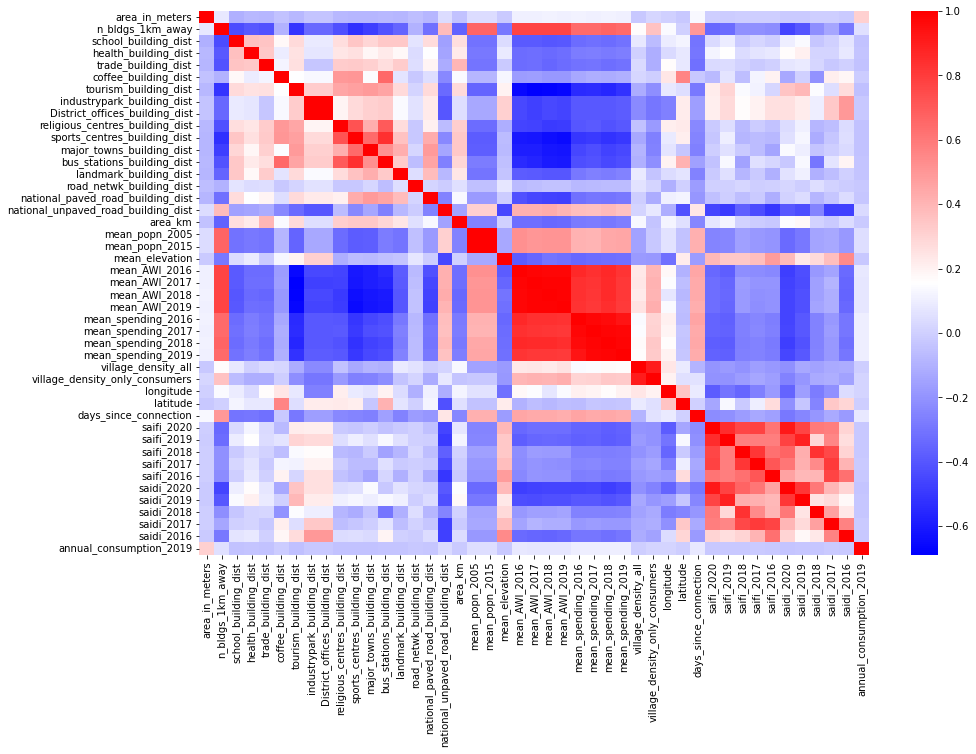

CPU times: user 2.45 s, sys: 77.2 ms, total: 2.53 s
Wall time: 2.53 s


In [14]:
%%time
#Using Pearson Correlation
plt.figure(figsize=(15,10))
# drop categorical features
X_y_no_cats = X_y.drop(['majority_2015','majority_2010','majority_2000','majority_1990',],axis=1)
cor = X_y_no_cats.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.bwr)
plt.show()

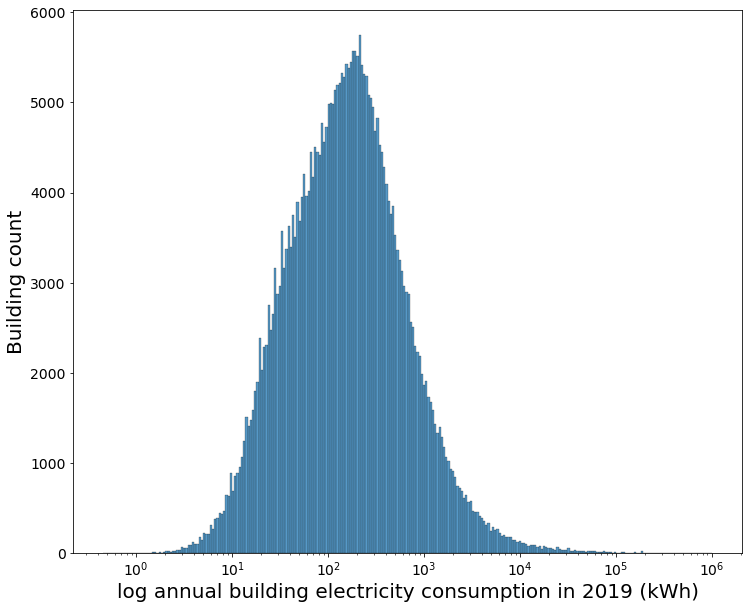

CPU times: user 1.06 s, sys: 4.46 ms, total: 1.07 s
Wall time: 1.07 s


In [6]:
%%time
# histogram of consumption
fontsize=20
tckfz = 14
fig, ax = plt.subplots(1, figsize=(12, 10))
sns.histplot(data=y, x='annual_consumption_2019',log_scale=True,ax=ax)
plt.xlabel('log annual building electricity consumption in 2019 (kWh)',fontsize=fontsize)
plt.ylabel('Building count', fontsize=fontsize)
plt.xticks(fontsize=tckfz)
plt.yticks(fontsize=tckfz)
# plt.xlim([0,2000])
plt.show()

0


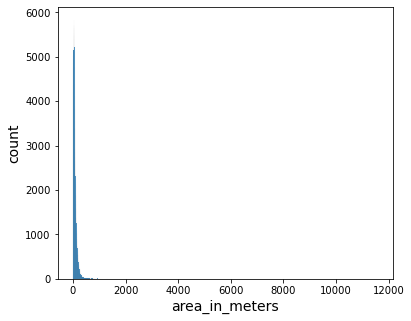

1


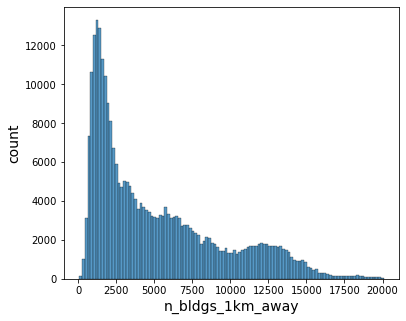

2


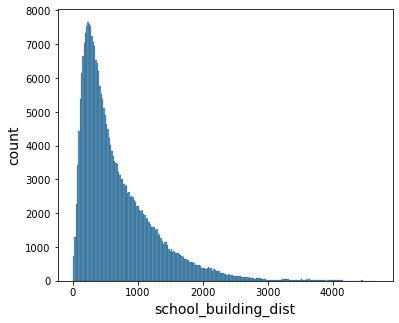

3


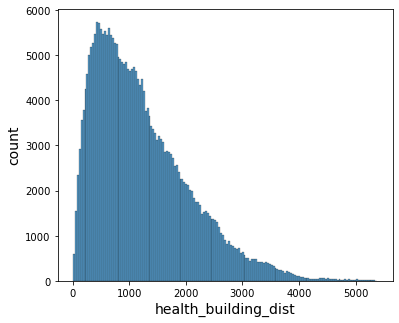

4


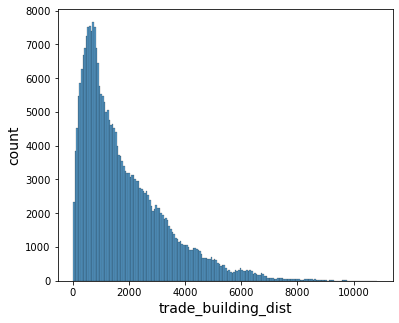

5


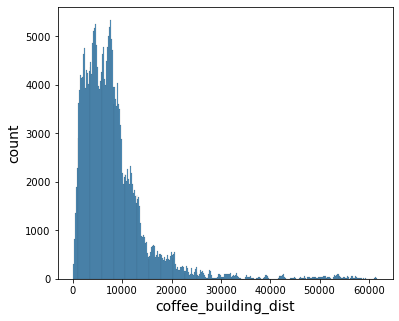

6


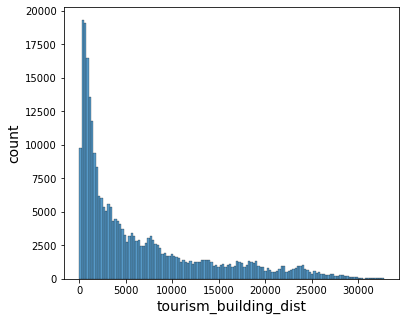

7


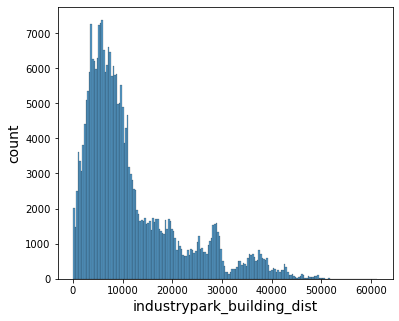

8


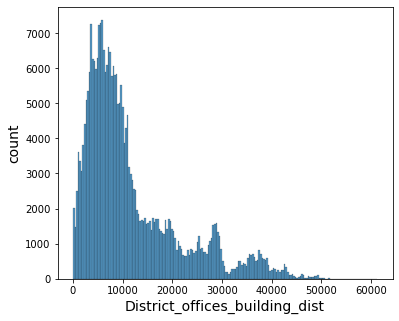

9


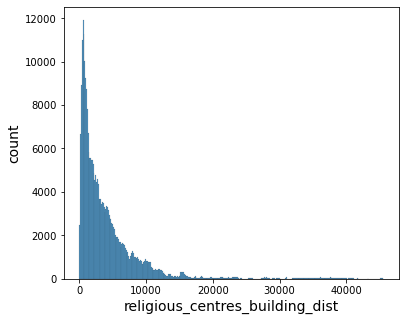

10


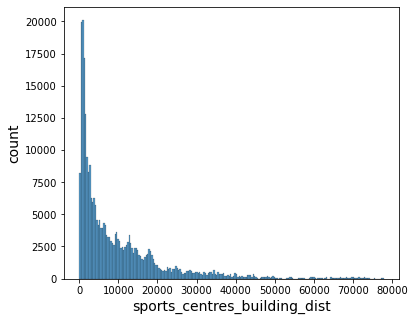

11


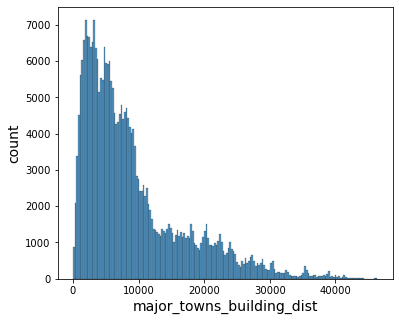

12


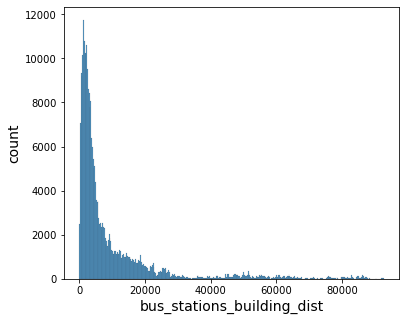

13


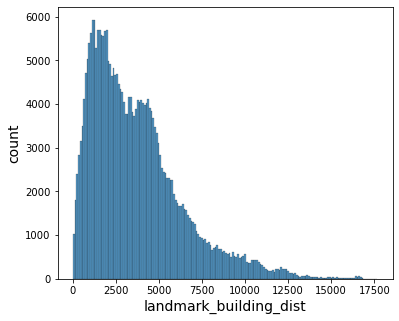

14


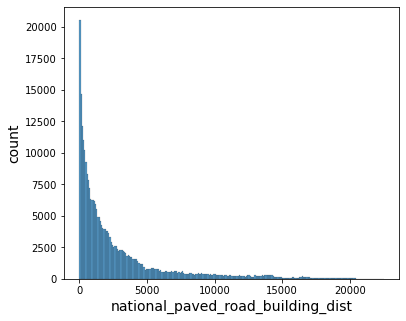

15


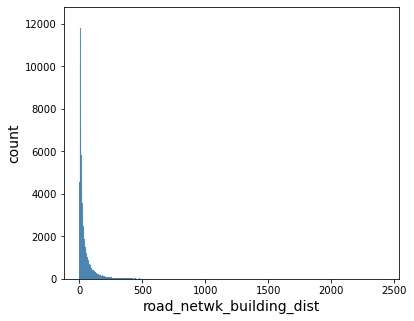

16


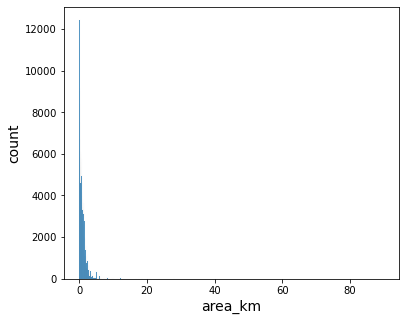

17


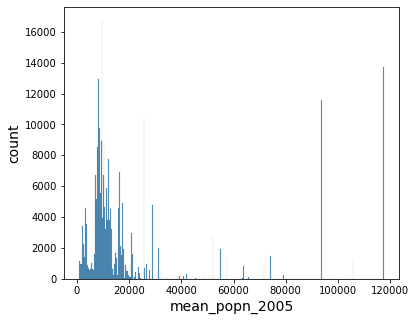

18


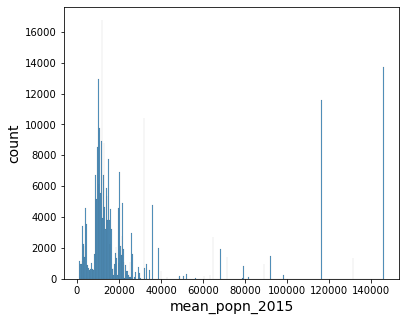

19


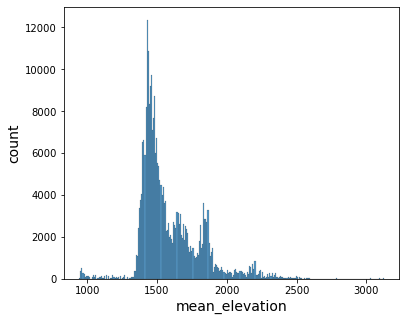

20


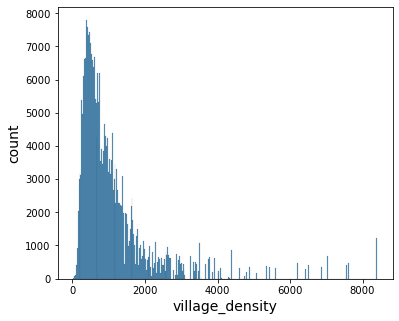

21


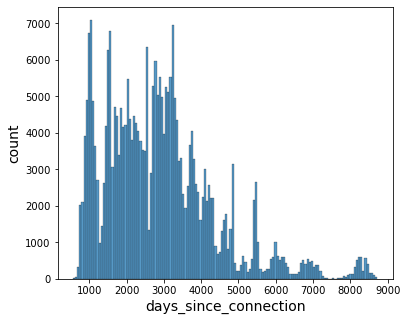

22


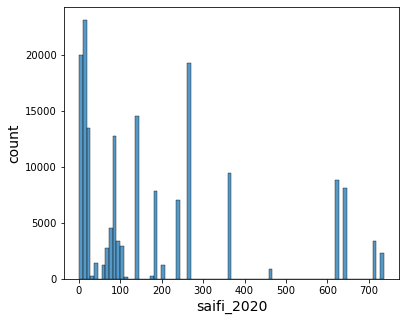

23


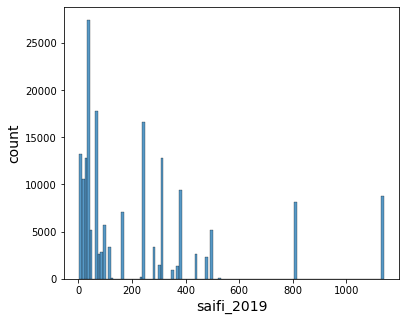

24


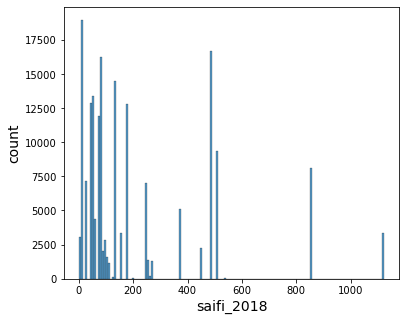

25


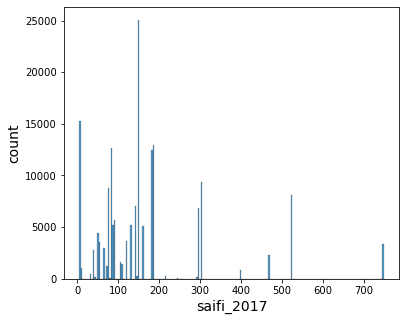

26


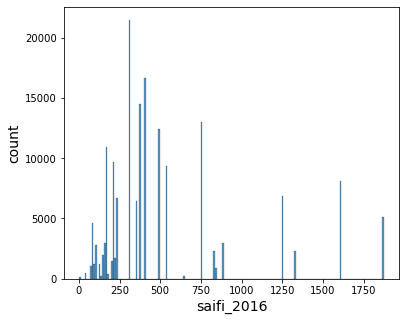

27


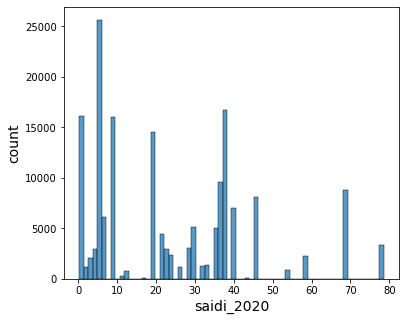

28


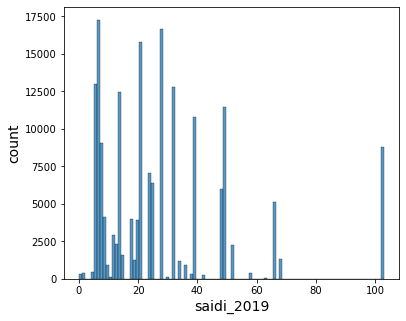

29


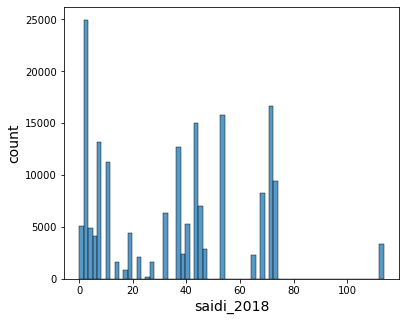

30


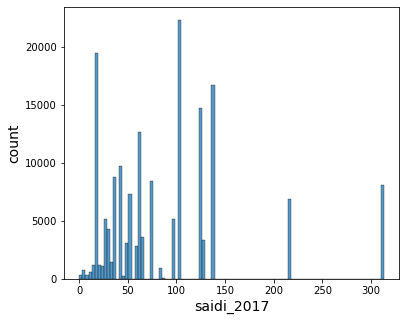

31


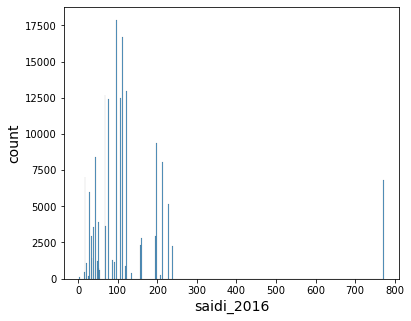

CPU times: user 32.4 s, sys: 151 ms, total: 32.5 s
Wall time: 32.7 s


In [21]:
%%time
cols=['area_in_meters', 'n_bldgs_1km_away', 'school_building_dist',
       'health_building_dist', 'trade_building_dist', 'coffee_building_dist',
       'tourism_building_dist', 'industrypark_building_dist',
       'District_offices_building_dist', 'religious_centres_building_dist',
       'sports_centres_building_dist', 'major_towns_building_dist',
       'bus_stations_building_dist', 'landmark_building_dist',
        'national_paved_road_building_dist',
       'road_netwk_building_dist', 'area_km', 'mean_popn_2005',
       'mean_popn_2015', 'mean_elevation', 'village_density',
       'days_since_connection', 'saifi_2020', 'saifi_2019', 'saifi_2018',
       'saifi_2017', 'saifi_2016', 'saidi_2020', 'saidi_2019', 'saidi_2018',
       'saidi_2017', 'saidi_2016']
# histogram of consumption

for i in range(0,len(cols)):
    fontsize=14
    fig, ax = plt.subplots(1, figsize=(6, 5))
    print(i)
    sns.histplot(data=X, x=cols[i],log_scale=False,ax=ax)
    plt.ylabel('count',fontsize=fontsize)
    plt.xlabel(cols[i],fontsize=fontsize)
    plt.show()

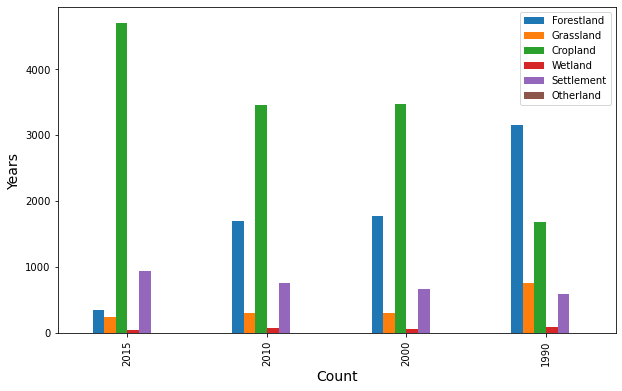

CPU times: user 223 ms, sys: 0 ns, total: 223 ms
Wall time: 228 ms


In [47]:
%%time
barchart_df = X[['majority_2015','majority_2010','majority_2000','majority_1990',]]
lc_15 = barchart_df.groupby(['majority_2015'])['majority_2015'].count()
lc_10 = barchart_df.groupby(['majority_2010'])['majority_2010'].count()
lc_00 = barchart_df.groupby(['majority_2000'])['majority_2000'].count()
lc_90 = barchart_df.groupby(['majority_1990'])['majority_1990'].count()

lc = pd.concat([lc_15, lc_10, lc_00, lc_90], axis=1)
lc = lc.rename(columns={'majority_2015':'2015','majority_2010':'2010','majority_2000':'2000','majority_1990':'1990'})
lc = lc.T
lc = lc.rename(columns={1:'Forestland',3:'Cropland',5:'Settlement',2:'Grassland',4:'Wetland',6:'Otherland'})
fontsize=14
fig, ax = plt.subplots(1, figsize=(10, 6))
lc.plot(y=[0,1,2,3,4,5], kind='bar',ax=ax)
plt.xlabel('Count',fontsize=fontsize)
plt.ylabel('Years',fontsize=fontsize)
plt.show()

## Target and Features

In [17]:
# Categorical features
if setting == 'HH':
    cat_features = ['majority_2015','majority_2010','majority_2000','majority_1990',
                         'class','status','settlement','eguide_categories']
    print('Note that setting is Household Level')

if setting == 'Village':
    cat_features = ['majority_2015','majority_2010','majority_2000','majority_1990',
                         ]
    print('Note that setting is Village Level')

X_cats = X[cat_features]
X_cats_transformed = ohe.fit_transform(X_cats)
X_cats = X[cat_features]

# log transformed features
log_cols=['area_in_meters', 'n_bldgs_1km_away', 'school_building_dist',
       'health_building_dist', 'trade_building_dist',
       'tourism_building_dist', 'industrypark_building_dist',
       'District_offices_building_dist', 'religious_centres_building_dist',
       'sports_centres_building_dist', 'major_towns_building_dist',
       'bus_stations_building_dist', 'landmark_building_dist',
        'national_paved_road_building_dist',
       'national_unpaved_road_building_dist','road_netwk_building_dist', 'area_km'] 
# log features
for log_col in log_cols:
    X[f'{log_col}_log'] = np.log(X[log_col]+1)

# Numerical Features
num_features = X.drop(cat_features,axis=1).columns.tolist()

Note that setting is Village Level


## Ridge Regression

### Regression on households

{'alpha': 1}
-0.5229306853533089
score: 0.6520912163805062


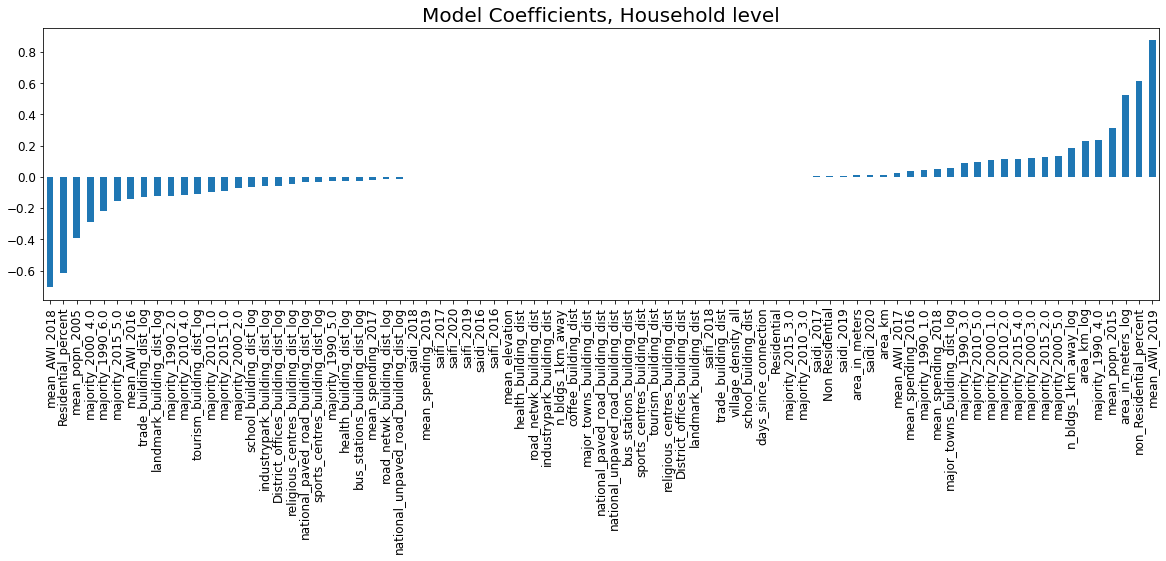

CPU times: user 1.97 s, sys: 9 ms, total: 1.98 s
Wall time: 1.99 s


In [18]:
%%time

# features and target variable
cat_features_transformed = ohe.fit_transform(X[cat_features])
cat_features_df = pd.DataFrame(data=cat_features_transformed.toarray(), columns=ohe.get_feature_names_out().tolist())
features_df = pd.concat([X[num_features].reset_index(drop=True),cat_features_df], axis=1, join='inner')
features = features_df
target = np.log(y['annual_consumption_2019'])

# Data training and testing split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100)

# Ridge regression model
ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X_train,y_train)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

alpha = ridge_regressor.best_params_['alpha']
ridgeReg = Ridge(alpha=alpha)
ridgeReg.fit(X_train,y_train)
y_pred = ridgeReg.predict(X_test)
score = ridgeReg.score(X_test, y_test)
print(f'score: {score}')

predictors = X_train.columns
coef_HH = pd.Series(ridgeReg.coef_.flatten(),predictors).sort_values()
plt.figure(figsize=(20,5))
coef_HH.plot(kind='bar', title='Model Coefficients, Household level', fontsize=12)
plt.title('Model Coefficients, Household level', fontsize=20)
plt.show()

### Regression on Villages

{'alpha': 1}
-0.5229306853533089
score: 0.6520912163805062
RMSE: 0.7069556318369723


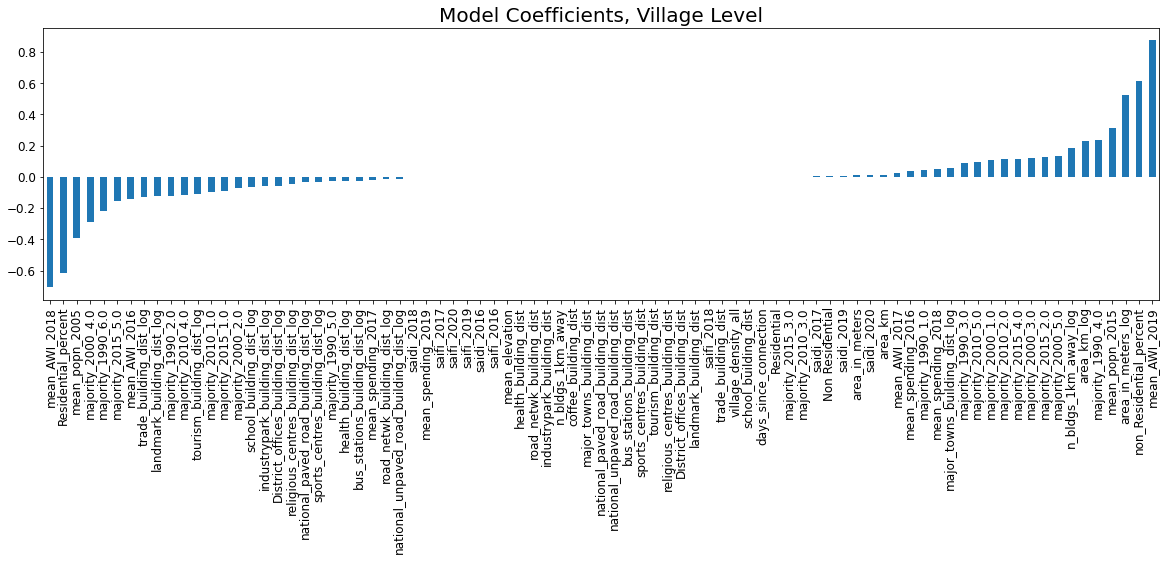

CPU times: user 2.16 s, sys: 30.9 ms, total: 2.19 s
Wall time: 2.2 s


In [19]:
%%time

# features and target variable
cat_features_transformed = ohe.fit_transform(X[cat_features])
cat_features_df = pd.DataFrame(data=cat_features_transformed.toarray(), columns=ohe.get_feature_names_out().tolist())
features_df = pd.concat([X[num_features].reset_index(drop=True),cat_features_df], axis=1, join='inner')
features = features_df
target = np.log(y['annual_consumption_2019'])

# Data training and testing split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100)

# Ridge regression model
ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X_train,y_train)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

alpha = ridge_regressor.best_params_['alpha']
ridgeReg = Ridge(alpha=alpha)
ridgeReg.fit(X_train,y_train)
y_pred = ridgeReg.predict(X_test)
score = ridgeReg.score(X_test, y_test)
rmse  = mean_squared_error(y_test, y_pred, squared=False)
print(f'score: {score}')
print(f'RMSE: {rmse}')

predictors = X_train.columns
coef_village = pd.Series(ridgeReg.coef_.flatten(),predictors).sort_values()
plt.figure(figsize=(20,5))
coef_village.plot(kind='bar', title='Model Coefficients, Village Level', fontsize=12)
plt.title('Model Coefficients, Village Level', fontsize=20)
plt.show()

## XGBOOST

### Household level

In [11]:
%%time
# features and target variable
cat_features_transformed = ohe.fit_transform(X[cat_features])
cat_features_df = pd.DataFrame(data=cat_features_transformed.toarray(), columns=ohe.get_feature_names_out().tolist())
features_df = pd.concat([X[num_features].reset_index(drop=True),cat_features_df], axis=1, join='inner')
features = features_df
target = np.log(y['annual_consumption_2019'])

# Data training and testing split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

# Using best trial parameters
model = xgb.XGBRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)
rmse  = mean_squared_error(y_test, y_pred, squared=False)
print(f'score: {score}')
print(f'RMSE: {rmse}')


score: 0.5703030690832447
RMSE: 0.9344379347071409
CPU times: user 559 ms, sys: 25 ms, total: 584 ms
Wall time: 588 ms


### Village level

In [39]:
%%time
# features and target variable
cat_features_transformed = ohe.fit_transform(X[cat_features])
cat_features_df = pd.DataFrame(data=cat_features_transformed.toarray(), columns=ohe.get_feature_names_out().tolist())
features_df = pd.concat([X[num_features].reset_index(drop=True),cat_features_df], axis=1, join='inner')
features = features_df
target = np.log(y['annual_consumption_2019'])

# Data training and testing split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

def objective(trial,data=X_train,target=y_train):
    '''
    Function to implement hyperparameter optimization using optuna
    '''
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5,0.6,0.7, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.1,0.3]),
        'n_estimators': 500,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9]),
        'random_state': trial.suggest_categorical('random_state', [0]),
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=50,verbose=True)
    
    preds = model.predict(test_x)
        
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

# Hyperparameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
Best_trial = study.best_trial.params

[I 2022-12-20 14:01:26,402] A new study created in memory with name: no-name-5a330eaf-9518-4af7-9ad3-fbcf5ee7dc79


X_train shape: (5043, 83)
y_train shape: (5043,)
[0]	validation_0-rmse:4.18124
[1]	validation_0-rmse:3.77826
[2]	validation_0-rmse:3.41545
[3]	validation_0-rmse:3.09242
[4]	validation_0-rmse:2.80175
[5]	validation_0-rmse:2.54099
[6]	validation_0-rmse:2.30937
[7]	validation_0-rmse:2.10327
[8]	validation_0-rmse:1.91881
[9]	validation_0-rmse:1.75340
[10]	validation_0-rmse:1.60927
[11]	validation_0-rmse:1.47783
[12]	validation_0-rmse:1.36309
[13]	validation_0-rmse:1.26172
[14]	validation_0-rmse:1.17056
[15]	validation_0-rmse:1.09027
[16]	validation_0-rmse:1.02190
[17]	validation_0-rmse:0.96412
[18]	validation_0-rmse:0.91143
[19]	validation_0-rmse:0.86791
[20]	validation_0-rmse:0.83258
[21]	validation_0-rmse:0.79993
[22]	validation_0-rmse:0.77289
[23]	validation_0-rmse:0.75134
[24]	validation_0-rmse:0.73346
[25]	validation_0-rmse:0.71755
[26]	validation_0-rmse:0.70401
[27]	validation_0-rmse:0.69346
[28]	validation_0-rmse:0.68486
[29]	validation_0-rmse:0.67628
[30]	validation_0-rmse:0.66983


[I 2022-12-20 14:01:32,039] Trial 0 finished with value: 0.6381992694330471 and parameters: {'lambda': 0.09820161237327996, 'alpha': 1.56653037093349, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'random_state': 0}. Best is trial 0 with value: 0.6381992694330471.


[0]	validation_0-rmse:4.18455
[1]	validation_0-rmse:3.77411
[2]	validation_0-rmse:3.41183
[3]	validation_0-rmse:3.08485
[4]	validation_0-rmse:2.79145
[5]	validation_0-rmse:2.52838
[6]	validation_0-rmse:2.29330
[7]	validation_0-rmse:2.08204
[8]	validation_0-rmse:1.89600
[9]	validation_0-rmse:1.72692
[10]	validation_0-rmse:1.57914
[11]	validation_0-rmse:1.44923
[12]	validation_0-rmse:1.33525
[13]	validation_0-rmse:1.23244
[14]	validation_0-rmse:1.14094
[15]	validation_0-rmse:1.06393
[16]	validation_0-rmse:0.99709
[17]	validation_0-rmse:0.94002
[18]	validation_0-rmse:0.89034
[19]	validation_0-rmse:0.84682
[20]	validation_0-rmse:0.81124
[21]	validation_0-rmse:0.78221
[22]	validation_0-rmse:0.75561
[23]	validation_0-rmse:0.73382
[24]	validation_0-rmse:0.71665
[25]	validation_0-rmse:0.70269
[26]	validation_0-rmse:0.68940
[27]	validation_0-rmse:0.68057
[28]	validation_0-rmse:0.67177
[29]	validation_0-rmse:0.66421
[30]	validation_0-rmse:0.65863
[31]	validation_0-rmse:0.65429
[32]	validation_0-

[I 2022-12-20 14:01:34,810] Trial 1 finished with value: 0.6377185948497807 and parameters: {'lambda': 0.006010645863562756, 'alpha': 0.0013794650605604471, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 0}. Best is trial 0 with value: 0.6381992694330471.


[0]	validation_0-rmse:3.30034
[1]	validation_0-rmse:2.37674
[2]	validation_0-rmse:1.74257
[3]	validation_0-rmse:1.32062
[4]	validation_0-rmse:1.04751
[5]	validation_0-rmse:0.87961
[6]	validation_0-rmse:0.77792
[7]	validation_0-rmse:0.71474
[8]	validation_0-rmse:0.67909
[9]	validation_0-rmse:0.66018
[10]	validation_0-rmse:0.65067
[11]	validation_0-rmse:0.64278
[12]	validation_0-rmse:0.63947
[13]	validation_0-rmse:0.63542
[14]	validation_0-rmse:0.63562
[15]	validation_0-rmse:0.63376
[16]	validation_0-rmse:0.63030
[17]	validation_0-rmse:0.62991
[18]	validation_0-rmse:0.62850
[19]	validation_0-rmse:0.62791
[20]	validation_0-rmse:0.62687
[21]	validation_0-rmse:0.62399
[22]	validation_0-rmse:0.62481
[23]	validation_0-rmse:0.62412
[24]	validation_0-rmse:0.62409
[25]	validation_0-rmse:0.62393
[26]	validation_0-rmse:0.62588
[27]	validation_0-rmse:0.62534
[28]	validation_0-rmse:0.62541
[29]	validation_0-rmse:0.62456
[30]	validation_0-rmse:0.62454
[31]	validation_0-rmse:0.62690
[32]	validation_0-

[I 2022-12-20 14:01:36,374] Trial 2 finished with value: 0.6239301596777072 and parameters: {'lambda': 2.0849510640577322, 'alpha': 0.07970757988318142, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3, 'max_depth': 5, 'random_state': 0}. Best is trial 0 with value: 0.6381992694330471.


[0]	validation_0-rmse:3.29301
[1]	validation_0-rmse:2.36974
[2]	validation_0-rmse:1.73627
[3]	validation_0-rmse:1.32016
[4]	validation_0-rmse:1.04183
[5]	validation_0-rmse:0.87019
[6]	validation_0-rmse:0.77290
[7]	validation_0-rmse:0.71344
[8]	validation_0-rmse:0.68300
[9]	validation_0-rmse:0.67020
[10]	validation_0-rmse:0.65750
[11]	validation_0-rmse:0.65548
[12]	validation_0-rmse:0.65223
[13]	validation_0-rmse:0.65243
[14]	validation_0-rmse:0.65350
[15]	validation_0-rmse:0.65518
[16]	validation_0-rmse:0.64976
[17]	validation_0-rmse:0.65611
[18]	validation_0-rmse:0.65687
[19]	validation_0-rmse:0.65639
[20]	validation_0-rmse:0.65412
[21]	validation_0-rmse:0.65558
[22]	validation_0-rmse:0.65488
[23]	validation_0-rmse:0.65622
[24]	validation_0-rmse:0.65778
[25]	validation_0-rmse:0.65640
[26]	validation_0-rmse:0.65551
[27]	validation_0-rmse:0.65607
[28]	validation_0-rmse:0.65550
[29]	validation_0-rmse:0.65639
[30]	validation_0-rmse:0.65771
[31]	validation_0-rmse:0.65824
[32]	validation_0-

[I 2022-12-20 14:01:38,286] Trial 3 finished with value: 0.649758587292887 and parameters: {'lambda': 0.6474108533041023, 'alpha': 0.012732723387163882, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3, 'max_depth': 7, 'random_state': 0}. Best is trial 3 with value: 0.649758587292887.


[0]	validation_0-rmse:3.30181
[1]	validation_0-rmse:2.37846
[2]	validation_0-rmse:1.75816
[3]	validation_0-rmse:1.33642
[4]	validation_0-rmse:1.05946
[5]	validation_0-rmse:0.88159
[6]	validation_0-rmse:0.78622
[7]	validation_0-rmse:0.72590
[8]	validation_0-rmse:0.68910
[9]	validation_0-rmse:0.67203
[10]	validation_0-rmse:0.66312
[11]	validation_0-rmse:0.65921
[12]	validation_0-rmse:0.65983
[13]	validation_0-rmse:0.65390
[14]	validation_0-rmse:0.65395
[15]	validation_0-rmse:0.65273
[16]	validation_0-rmse:0.65101
[17]	validation_0-rmse:0.65445
[18]	validation_0-rmse:0.65234
[19]	validation_0-rmse:0.65374
[20]	validation_0-rmse:0.65341
[21]	validation_0-rmse:0.65389
[22]	validation_0-rmse:0.65433
[23]	validation_0-rmse:0.65405
[24]	validation_0-rmse:0.65693
[25]	validation_0-rmse:0.65653
[26]	validation_0-rmse:0.65875
[27]	validation_0-rmse:0.66020
[28]	validation_0-rmse:0.66241
[29]	validation_0-rmse:0.66249
[30]	validation_0-rmse:0.66309
[31]	validation_0-rmse:0.66619
[32]	validation_0-

[I 2022-12-20 14:01:40,450] Trial 4 finished with value: 0.6510083431092868 and parameters: {'lambda': 2.4202467419264804, 'alpha': 0.3733230905852076, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.3, 'max_depth': 7, 'random_state': 0}. Best is trial 4 with value: 0.6510083431092868.


[0]	validation_0-rmse:3.28703
[1]	validation_0-rmse:2.35567
[2]	validation_0-rmse:1.72236
[3]	validation_0-rmse:1.30236
[4]	validation_0-rmse:1.03059
[5]	validation_0-rmse:0.86011
[6]	validation_0-rmse:0.76531
[7]	validation_0-rmse:0.70646
[8]	validation_0-rmse:0.67859
[9]	validation_0-rmse:0.65920
[10]	validation_0-rmse:0.65298
[11]	validation_0-rmse:0.64889
[12]	validation_0-rmse:0.64766
[13]	validation_0-rmse:0.64607
[14]	validation_0-rmse:0.64607
[15]	validation_0-rmse:0.64913
[16]	validation_0-rmse:0.64547
[17]	validation_0-rmse:0.64075
[18]	validation_0-rmse:0.64036
[19]	validation_0-rmse:0.64381
[20]	validation_0-rmse:0.64276
[21]	validation_0-rmse:0.64274
[22]	validation_0-rmse:0.64236
[23]	validation_0-rmse:0.64284
[24]	validation_0-rmse:0.64433
[25]	validation_0-rmse:0.64625
[26]	validation_0-rmse:0.64886
[27]	validation_0-rmse:0.64927
[28]	validation_0-rmse:0.64791
[29]	validation_0-rmse:0.64960
[30]	validation_0-rmse:0.65102
[31]	validation_0-rmse:0.65535
[32]	validation_0-

[I 2022-12-20 14:01:42,049] Trial 5 finished with value: 0.6403623868011583 and parameters: {'lambda': 0.083819908535292, 'alpha': 0.9542696442080044, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.3, 'max_depth': 5, 'random_state': 0}. Best is trial 4 with value: 0.6510083431092868.


[0]	validation_0-rmse:4.18159
[1]	validation_0-rmse:3.77784
[2]	validation_0-rmse:3.41410
[3]	validation_0-rmse:3.08881
[4]	validation_0-rmse:2.79904
[5]	validation_0-rmse:2.54038
[6]	validation_0-rmse:2.30948
[7]	validation_0-rmse:2.10246
[8]	validation_0-rmse:1.91733
[9]	validation_0-rmse:1.74833
[10]	validation_0-rmse:1.60211
[11]	validation_0-rmse:1.47196
[12]	validation_0-rmse:1.35573
[13]	validation_0-rmse:1.25501
[14]	validation_0-rmse:1.16179
[15]	validation_0-rmse:1.08436
[16]	validation_0-rmse:1.01436
[17]	validation_0-rmse:0.95560
[18]	validation_0-rmse:0.90478
[19]	validation_0-rmse:0.86160
[20]	validation_0-rmse:0.82184
[21]	validation_0-rmse:0.79076
[22]	validation_0-rmse:0.76443
[23]	validation_0-rmse:0.74169
[24]	validation_0-rmse:0.72339
[25]	validation_0-rmse:0.70833
[26]	validation_0-rmse:0.69392
[27]	validation_0-rmse:0.68309
[28]	validation_0-rmse:0.67216
[29]	validation_0-rmse:0.66357
[30]	validation_0-rmse:0.65602
[31]	validation_0-rmse:0.65155
[32]	validation_0-

[I 2022-12-20 14:01:45,143] Trial 6 finished with value: 0.6223109724244928 and parameters: {'lambda': 0.5319309747636226, 'alpha': 0.02250524400572594, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 0}. Best is trial 4 with value: 0.6510083431092868.


[0]	validation_0-rmse:4.18107
[1]	validation_0-rmse:3.77961
[2]	validation_0-rmse:3.41665
[3]	validation_0-rmse:3.08959
[4]	validation_0-rmse:2.80180
[5]	validation_0-rmse:2.54073
[6]	validation_0-rmse:2.31012
[7]	validation_0-rmse:2.10037
[8]	validation_0-rmse:1.91134
[9]	validation_0-rmse:1.74613
[10]	validation_0-rmse:1.59831
[11]	validation_0-rmse:1.46894
[12]	validation_0-rmse:1.35267
[13]	validation_0-rmse:1.24998
[14]	validation_0-rmse:1.15802
[15]	validation_0-rmse:1.08101
[16]	validation_0-rmse:1.01117
[17]	validation_0-rmse:0.95236
[18]	validation_0-rmse:0.90081
[19]	validation_0-rmse:0.85707
[20]	validation_0-rmse:0.81821
[21]	validation_0-rmse:0.78746
[22]	validation_0-rmse:0.76042
[23]	validation_0-rmse:0.73944
[24]	validation_0-rmse:0.72006
[25]	validation_0-rmse:0.70278
[26]	validation_0-rmse:0.69032
[27]	validation_0-rmse:0.67910
[28]	validation_0-rmse:0.67129
[29]	validation_0-rmse:0.66528
[30]	validation_0-rmse:0.65971
[31]	validation_0-rmse:0.65555
[32]	validation_0-

[I 2022-12-20 14:01:49,149] Trial 7 finished with value: 0.6383904581747895 and parameters: {'lambda': 0.22740905658383567, 'alpha': 0.005558571519488624, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 9, 'random_state': 0}. Best is trial 4 with value: 0.6510083431092868.


[0]	validation_0-rmse:3.28517
[1]	validation_0-rmse:2.34392
[2]	validation_0-rmse:1.71072
[3]	validation_0-rmse:1.29713
[4]	validation_0-rmse:1.02956
[5]	validation_0-rmse:0.86507
[6]	validation_0-rmse:0.76588
[7]	validation_0-rmse:0.71396
[8]	validation_0-rmse:0.68999
[9]	validation_0-rmse:0.67556
[10]	validation_0-rmse:0.67061
[11]	validation_0-rmse:0.66764
[12]	validation_0-rmse:0.66633
[13]	validation_0-rmse:0.66319
[14]	validation_0-rmse:0.66192
[15]	validation_0-rmse:0.66389
[16]	validation_0-rmse:0.66414
[17]	validation_0-rmse:0.67220
[18]	validation_0-rmse:0.67258
[19]	validation_0-rmse:0.67579
[20]	validation_0-rmse:0.66666
[21]	validation_0-rmse:0.66625
[22]	validation_0-rmse:0.66012
[23]	validation_0-rmse:0.66628
[24]	validation_0-rmse:0.66805
[25]	validation_0-rmse:0.67127
[26]	validation_0-rmse:0.67176
[27]	validation_0-rmse:0.67491
[28]	validation_0-rmse:0.67441
[29]	validation_0-rmse:0.67716
[30]	validation_0-rmse:0.67812
[31]	validation_0-rmse:0.68130
[32]	validation_0-

[I 2022-12-20 14:01:50,360] Trial 8 finished with value: 0.6601203812283043 and parameters: {'lambda': 0.0014502464823688427, 'alpha': 0.2788889886820891, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.3, 'max_depth': 5, 'random_state': 0}. Best is trial 8 with value: 0.6601203812283043.


[0]	validation_0-rmse:3.29243
[1]	validation_0-rmse:2.36915
[2]	validation_0-rmse:1.73374
[3]	validation_0-rmse:1.31525
[4]	validation_0-rmse:1.05359
[5]	validation_0-rmse:0.88369
[6]	validation_0-rmse:0.79115
[7]	validation_0-rmse:0.74174
[8]	validation_0-rmse:0.71489
[9]	validation_0-rmse:0.70321
[10]	validation_0-rmse:0.69455
[11]	validation_0-rmse:0.69320
[12]	validation_0-rmse:0.69394
[13]	validation_0-rmse:0.69762
[14]	validation_0-rmse:0.70044
[15]	validation_0-rmse:0.70103
[16]	validation_0-rmse:0.70512
[17]	validation_0-rmse:0.70852
[18]	validation_0-rmse:0.71254
[19]	validation_0-rmse:0.71223
[20]	validation_0-rmse:0.71211
[21]	validation_0-rmse:0.71211
[22]	validation_0-rmse:0.71112
[23]	validation_0-rmse:0.71139
[24]	validation_0-rmse:0.71084
[25]	validation_0-rmse:0.71046
[26]	validation_0-rmse:0.71406
[27]	validation_0-rmse:0.71642
[28]	validation_0-rmse:0.71869
[29]	validation_0-rmse:0.71920
[30]	validation_0-rmse:0.72092
[31]	validation_0-rmse:0.72139
[32]	validation_0-

[I 2022-12-20 14:01:52,547] Trial 9 finished with value: 0.6931957559295774 and parameters: {'lambda': 0.42645552857454533, 'alpha': 0.003989947687520578, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.3, 'max_depth': 9, 'random_state': 0}. Best is trial 9 with value: 0.6931957559295774.


Number of finished trials: 10
Best trial: {'lambda': 0.42645552857454533, 'alpha': 0.003989947687520578, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.3, 'max_depth': 9, 'random_state': 0}
CPU times: user 25.2 s, sys: 92.8 ms, total: 25.3 s
Wall time: 26.2 s


In [24]:
%%time
# Using best trial parameters
model = xgb.XGBRegressor(**Best_trial)
model.fit(X_train,y_train)
# model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=10,verbose=True)
score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)
rmse  = mean_squared_error(y_test, y_pred, squared=False)
print(f'score: {score}')
print(f'RMSE: {rmse}')


score: 0.6315582520706577
RMSE: 0.7275182275801962
CPU times: user 3.54 s, sys: 5.98 ms, total: 3.55 s
Wall time: 3.55 s


In [40]:
%%time
# using default parameters
model = xgb.XGBRegressor()
model.fit(X_train,y_train)
# model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=10,verbose=True)
score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)
rmse  = mean_squared_error(y_test, y_pred, squared=False)
print(f'score: {score}')
print(f'RMSE: {rmse}')

score: 0.6597028729164242
RMSE: 0.6991793661743505
CPU times: user 5.51 s, sys: 3.95 ms, total: 5.52 s
Wall time: 5.52 s


### SHAP Values

In [129]:
%%time
xgb_explainer = shap.Explainer(model)
xgb_shap_values = xgb_explainer(X_train)

CPU times: user 8.92 s, sys: 5 µs, total: 8.92 s
Wall time: 8.92 s


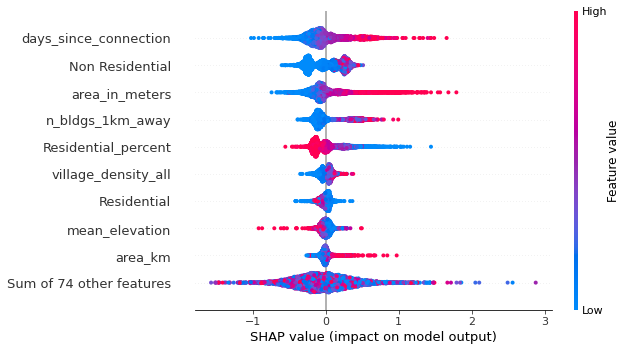

CPU times: user 765 ms, sys: 20.9 ms, total: 786 ms
Wall time: 793 ms


In [37]:
%%time
shap.plots.beeswarm(xgb_shap_values)

# Neural Network

### Household level

### Single layer

In [12]:
%%time
# features and target variable
cat_features_transformed = ohe.fit_transform(X[cat_features])
cat_features_df = pd.DataFrame(data=cat_features_transformed.toarray(), columns=ohe.get_feature_names_out().tolist())
features_df = pd.concat([X[num_features].reset_index(drop=True),cat_features_df], axis=1, join='inner')
features = features_df
target = np.log(y['annual_consumption_2019'])

# Data training and testing split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

# Normalization
features_normalizer = tf.keras.layers.Normalization(axis=-1)
features_normalizer.adapt(np.array(X_train))

# LINEAR REGRESSION
nn_linear_model = tf.keras.Sequential([
    features_normalizer,
    layers.Dense(units=1)
])

nn_linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

history = nn_linear_model.fit(
    X_train,
    y_train,
    epochs=20,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

X_train shape: (280061, 94)
y_train shape: (280061,)


2022-12-19 11:58:44.160123: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /rigel/opt/julia-1.3.1/lib:/rigel/opt/pcre2-10.35/lib:/cm/shared/apps/slurm/17.11.2/lib64/slurm:/cm/shared/apps/slurm/17.11.2/lib64
2022-12-19 11:58:44.160232: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-19 11:58:44.160308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (node023): /proc/driver/nvidia/version does not exist
2022-12-19 11:58:44.199071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

CPU times: user 2min 39s, sys: 3.59 s, total: 2min 43s
Wall time: 3min 37s


40/40 [==============================] - 0s 1ms/step
score: 0.6139928748403856
RMSE: 0.7446584507079769


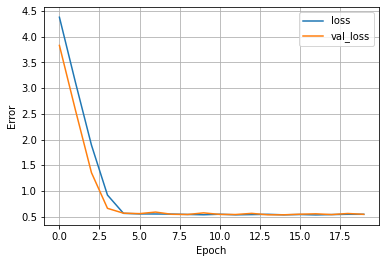

In [27]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
plot_loss(history)

# Score
y_preds = nn_linear_model.predict(X_test).flatten()
score = r2_score(y_test, y_preds, multioutput='variance_weighted')
rmse  = mean_squared_error(y_test, y_preds, squared=False)
print(f'score: {score}')
print(f'RMSE: {rmse}')

### DNN

In [14]:
%%time
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
drop_out_rate = 0.1

# Deep Neural Network
def build_and_compile_model(norm):
    model = keras.Sequential([
          norm,
          layers.Dense(n_neuron, activation=activation),
          layers.Dropout(drop_out_rate),
          layers.Dense(n_neuron, activation=activation),
          layers.Dropout(drop_out_rate),
          layers.Dense(1)
      ])

    model.compile(
                    optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss="mse", metrics=["mae", "acc"])
    return model
dnn_model = build_and_compile_model(features_normalizer)

history = dnn_model.fit(
    X_train,
    y_train,
    batch_size=minibatch_size,
    validation_split=0.2,
    verbose=0, epochs=num_epochs)

# score
y_preds = dnn_model.predict(X_test).flatten()
score = r2_score(y_test, y_preds, multioutput='variance_weighted')
rmse  = mean_squared_error(y_test, y_preds, squared=False)
print(f'score: {score}')
print(f'RMSE: {rmse}')

2188/2188 [==============================] - 2s 912us/step
score: 0.5474674594691549
RMSE: 0.9589461985193488
CPU times: user 4min 43s, sys: 3.99 s, total: 4min 47s
Wall time: 5min 28s


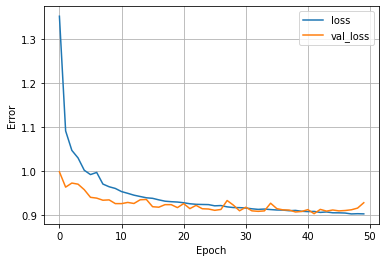

In [26]:
plot_loss(history)

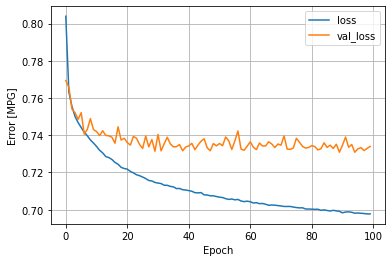

In [76]:
plot_loss(history)

## Village Level

### DNN

In [29]:
%%time

# features and target variable
cat_features_transformed = ohe.fit_transform(X[cat_features])
cat_features_df = pd.DataFrame(data=cat_features_transformed.toarray(), columns=ohe.get_feature_names_out().tolist())
features_df = pd.concat([X[num_features].reset_index(drop=True),cat_features_df], axis=1, join='inner')
features = features_df
target = np.log(y['annual_consumption_2019'])

# Data training and testing split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

# Normalization
features_normalizer = tf.keras.layers.Normalization(axis=-1)
features_normalizer.adapt(np.array(X_train))

# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
drop_out_rate = 0.1

# Deep Neural Network
def build_and_compile_model(norm):
    model = keras.Sequential([
          norm,
          layers.Dense(n_neuron, activation=activation),
          layers.Dropout(drop_out_rate),
          layers.Dense(n_neuron, activation=activation),
          layers.Dropout(drop_out_rate),
          layers.Dense(1)
      ])

    model.compile(
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss="mse", metrics=["mae", "acc"])
    return model
dnn_model = build_and_compile_model(features_normalizer)

history = dnn_model.fit(
    X_train,
    y_train,
    batch_size=minibatch_size,
    validation_split=0.2,
    verbose=0, epochs=num_epochs)
# score
y_preds = dnn_model.predict(X_test).flatten()
score = r2_score(y_test, y_preds, multioutput='variance_weighted')
rmse  = mean_squared_error(y_test, y_preds, squared=False)
print(f'score: {score}')
print(f'RMSE: {rmse}')

X_train shape: (5043, 83)
y_train shape: (5043,)
40/40 [==============================] - 0s 945us/step
score: 0.6542173601581189
RMSE: 0.7047921440835639
CPU times: user 7.65 s, sys: 85.5 ms, total: 7.73 s
Wall time: 11.6 s


In [36]:
%%time
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['annual_consumption_2019'],
    verbose=True,
    mode='regression'
)

CPU times: user 171 ms, sys: 1.01 ms, total: 172 ms
Wall time: 176 ms


In [45]:
%%time
for i in [1, 5, 10, 25]:
    print(f'Lime explanations for {i}th row')
    exp = explainer.explain_instance(X_test.values[i], dnn_model.predict, num_features=5)

    # Show the predictions
    exp.show_in_notebook(show_table=True)

Lime explanations for 1th row
157/157 [==============================] - 0s 897us/step
Intercept 5.445669241288411
Prediction_local [5.46064772]
Right: 5.027836


Lime explanations for 5th row
157/157 [==============================] - 0s 903us/step
Intercept 4.74602089084566
Prediction_local [6.4656461]
Right: 6.3368053


Lime explanations for 10th row
157/157 [==============================] - 0s 892us/step
Intercept 5.17871762193214
Prediction_local [5.37662858]
Right: 4.552976


Lime explanations for 25th row
157/157 [==============================] - 0s 901us/step
Intercept 5.380591427665702
Prediction_local [4.96752732]
Right: 4.5334992


CPU times: user 2min 4s, sys: 27.6 ms, total: 2min 4s
Wall time: 2min 5s


### Single layer

In [26]:
%%time
# features and target variable
cat_features_transformed = ohe.fit_transform(X[cat_features])
cat_features_df = pd.DataFrame(data=cat_features_transformed.toarray(), columns=ohe.get_feature_names_out().tolist())
features_df = pd.concat([X[num_features].reset_index(drop=True),cat_features_df], axis=1, join='inner')
features = features_df
target = np.log(y['annual_consumption_2019'])

# Data training and testing split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

# Normalization
features_normalizer = tf.keras.layers.Normalization(axis=-1)
features_normalizer.adapt(np.array(X_train))

# LINEAR REGRESSION
nn_linear_model = tf.keras.Sequential([
    features_normalizer,
    layers.Dense(units=1)
])

nn_linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

history = nn_linear_model.fit(
    X_train,
    y_train,
    epochs=20,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

X_train shape: (5043, 83)
y_train shape: (5043,)
CPU times: user 3.98 s, sys: 54 ms, total: 4.03 s
Wall time: 5.89 s


40/40 [==============================] - 0s 1ms/step
score: 0.6139928748403856
RMSE: 0.7446584507079769


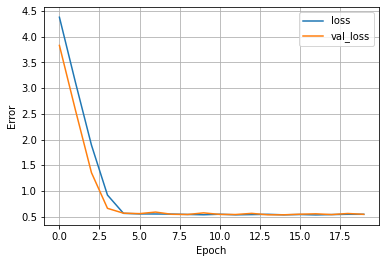

In [28]:
plot_loss(history)

# Score
y_preds = nn_linear_model.predict(X_test).flatten()
score = r2_score(y_test, y_preds, multioutput='variance_weighted')
rmse  = mean_squared_error(y_test, y_preds, squared=False)
print(f'score: {score}')
print(f'RMSE: {rmse}')

In [30]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (5043, 83)
y_train shape: (5043,)
